In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
from tqdm import tqdm

In [2]:
f = open("/code/data/datasets/common_hall/tracking_outputs/framewise_aggregation.json")
frame_to_predictions_map = json.load(f)
f = open("/code/data/datasets/common_hall/tracking_outputs/objectwise_aggregation.json")
objects_to_predictions_map = json.load(f)['annotations'] #the object_id attribute of frame_to_predictions_map are the keys of object_to_predictions_map

In [3]:
#get all the backtire keypoints for object 0
tire_dict = {}
for i in range(len(objects_to_predictions_map)):    
    tire_dict[f'obj_{i}_back_x'] = []
    tire_dict[f'obj_{i}_back_y'] = []
    tire_dict[f'obj_{i}_front_x'] = []
    tire_dict[f'obj_{i}_front_y'] = []
col_names = list(tire_dict.keys())

In [4]:
def validate_inclusion(_x, _y, _cx, _cy, _r):
    return (_x - _cx)**2 + (_y -_cy)**2 < _r**2

In [5]:
frame_path = '/code/data/datasets/frame_imgs'
frame_list = os.listdir(frame_path)
frame_border = True
rule0 = False
rule1 = False
rule2 = False
def get_keypoints(rule0, rule1, rule2):
    back_tire_x_list = []
    back_tire_y_list = []
    front_tire_x_list = []
    front_tire_y_list = []
    for frame_idx in range(len(frame_to_predictions_map)):
        frame = cv2.imread(str(Path(frame_path)/f'{frame_idx}.jpg'))
        if frame_border:
            img = cv2.rectangle(frame, (450, 200), (1280, 720), (0, 255, 0), thickness=4)
        objects_per_frame = frame_to_predictions_map[frame_idx]['annotations']
        for obj_idx in range(len(objects_per_frame)):
            back_tire_x = objects_per_frame[obj_idx]['keypoints'][0][0]
            back_tire_y =objects_per_frame[obj_idx]['keypoints'][0][1]
            front_tire_x = objects_per_frame[obj_idx]['keypoints'][1][0]
            front_tire_y = objects_per_frame[obj_idx]['keypoints'][1][1]
            x1, y1, x2, y2 = objects_per_frame[obj_idx]['bounding_box']
            #rule #0
            if rule0 == True:
                frame_save_path = Path('/code/data/datasets/rule0_imgs')
                if x1 < 600:
                    back_tire_x = -100
                    back_tire_y = -100
                    front_tire_x = -100
                    front_tire_y = -100

            #rule #1
            if rule1 == True:
                frame_save_path = Path('/code/data/datasets/rule1_imgs')
                if (back_tire_y <= y1 + int((y2 - y1)/2)):
                    back_tire_x = -100
                    back_tire_y = -100
                if (front_tire_y <= y1 + int((y2 - y1)/2)):
                    front_tire_x = -100
                    front_tire_y = -100
            #rule #2
            if rule2 == True:
                frame_save_path = Path('/code/data/datasets/rule2_imgs')
                if validate_inclusion(back_tire_x, back_tire_y, front_tire_x, front_tire_y, 20):
                    if np.array(objects_per_frame[obj_idx]['keypoints_scores']).argmax() == 0:
                        front_tire_x = -100
                        front_tire_y = -100
                    else:
                        back_tire_x = -100
                        back_tire_y = -100
            # img = cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), thickness=4)
            # img = cv2.circle(img, (int(back_tire_x), int(back_tire_y)), radius=5, color=(0, 0, 255), thickness=-1) #Blue: Backtire
            # img = cv2.circle(img, (int(front_tire_x), int(front_tire_y)), radius=5, color=(255, 0, 0), thickness=-1) #Red Front tire
            # cv2.imwrite(os.path.join(frame_save_path, f'{frame_idx}.jpg'), img)
            back_tire_x_list.append(back_tire_x)
            back_tire_y_list.append(back_tire_y)
            front_tire_x_list.append(front_tire_x)
            front_tire_y_list.append(front_tire_y)
    return back_tire_x_list, back_tire_y_list, front_tire_x_list, front_tire_y_list

Before any rules

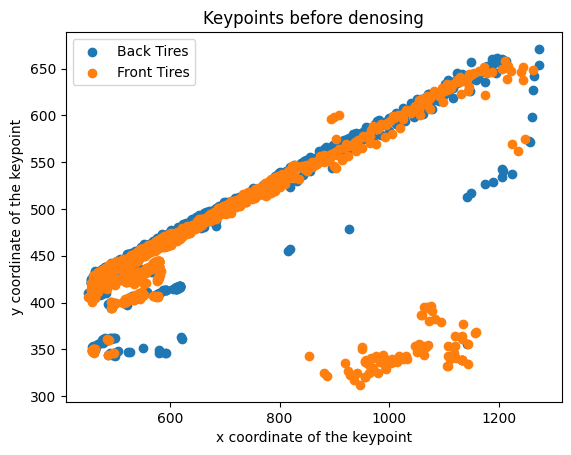

In [6]:
back_tire_x_list, back_tire_y_list, front_tire_x_list, front_tire_y_list = get_keypoints(False, False, False)
plt.scatter(back_tire_x_list, back_tire_y_list, label = "Back Tires");
plt.scatter(front_tire_x_list, front_tire_y_list, label = "Front Tires");
plt.legend();
plt.title("Keypoints before denosing");
plt.xlabel("x coordinate of the keypoint");
plt.ylabel("y coordinate of the keypoint");
# plt.xlim([500,1600])
# plt.ylim([400,800])

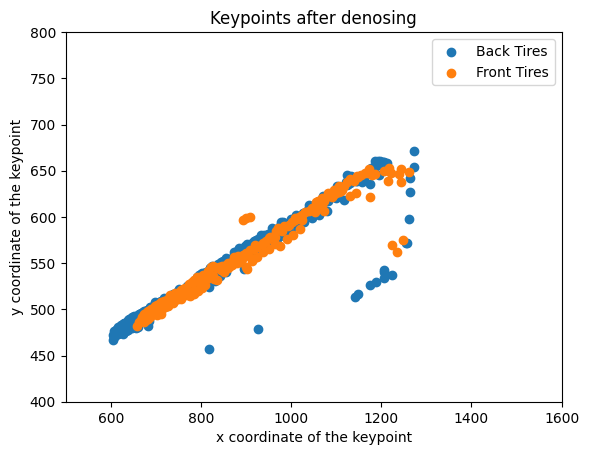

In [7]:
back_tire_x_list, back_tire_y_list, front_tire_x_list, front_tire_y_list = get_keypoints(True, True, True)
plt.scatter(back_tire_x_list, back_tire_y_list, label = "Back Tires");
plt.scatter(front_tire_x_list, front_tire_y_list, label = "Front Tires");
plt.legend();
plt.xlim([500,1600])
plt.ylim([400,800])
plt.title("Keypoints after denosing");
plt.xlabel("x coordinate of the keypoint");
plt.ylabel("y coordinate of the keypoint");

Let's plot objectwise points and see if if we can start calculating the speed.
It looks like I could impose another rule at x =1200 to filter out noise.

In [8]:
frame_path = '/code/data/datasets/frame_imgs'
frame_list = os.listdir(frame_path)
frame_border = True
rule0 = False
rule1 = False
rule2 = False
def get_objectwise_keypoints(rule0, rule1, rule2):
    objectwise_keypoints = {}
    for i in range(len(objects_to_predictions_map)):
        objectwise_keypoints[objects_to_predictions_map[i]['id']] = []
    for frame_idx in range(len(frame_to_predictions_map)):
        frame = cv2.imread(str(Path(frame_path)/f'{frame_idx}.jpg'))
        if frame_border:
            img = cv2.rectangle(frame, (450, 200), (1280, 720), (0, 255, 0), thickness=4)
        objects_per_frame = frame_to_predictions_map[frame_idx]['annotations']
        for obj_idx in range(len(objects_per_frame)):
            back_tire_x = objects_per_frame[obj_idx]['keypoints'][0][0]
            back_tire_y =objects_per_frame[obj_idx]['keypoints'][0][1]
            front_tire_x = objects_per_frame[obj_idx]['keypoints'][1][0]
            front_tire_y = objects_per_frame[obj_idx]['keypoints'][1][1]
            x1, y1, x2, y2 = objects_per_frame[obj_idx]['bounding_box']
            #rule #0
            if rule0 == True:
                frame_save_path = Path('/code/data/datasets/rule0_imgs')
                if x1 < 600 or x1>= 1100:
                    back_tire_x = -100
                    back_tire_y = -100
                    front_tire_x = -100
                    front_tire_y = -100

            #rule #1
            if rule1 == True:
                frame_save_path = Path('/code/data/datasets/rule1_imgs')
                if (back_tire_y <= y1 + int((y2 - y1)/2)):
                    back_tire_x = -100
                    back_tire_y = -100
                if (front_tire_y <= y1 + int((y2 - y1)/2)):
                    front_tire_x = -100
                    front_tire_y = -100
            #rule #2
            if rule2 == True:
                frame_save_path = Path('/code/data/datasets/rule2_imgs')
                if validate_inclusion(back_tire_x, back_tire_y, front_tire_x, front_tire_y, 20):
                    if np.array(objects_per_frame[obj_idx]['keypoints_scores']).argmax() == 0:
                        front_tire_x = -100
                        front_tire_y = -100
                    else:
                        back_tire_x = -100
                        back_tire_y = -100
            #rule #3
            if back_tire_x !=front_tire_x and front_tire_y != back_tire_y:
                front_tire_x = -100
                front_tire_y = -100
                back_tire_x = -100
                back_tire_y = -100

            # img = cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), thickness=4)
            # img = cv2.circle(img, (int(back_tire_x), int(back_tire_y)), radius=5, color=(0, 0, 255), thickness=-1) #Blue: Backtire
            # img = cv2.circle(img, (int(front_tire_x), int(front_tire_y)), radius=5, color=(255, 0, 0), thickness=-1) #Red Front tire
            # cv2.imwrite(os.path.join(frame_save_path, f'{frame_idx}.jpg'), img)
            # back_tire_x_list.append(back_tire_x)
            # back_tire_y_list.append(back_tire_y)
            # front_tire_x_list.append(front_tire_x)
            # front_tire_y_list.append(front_tire_y)
            objectwise_keypoints[objects_per_frame[obj_idx]['object_tracklet_id']].append((back_tire_x, back_tire_y, front_tire_x, front_tire_y))
    return objectwise_keypoints

16it [00:00, 159.28it/s]


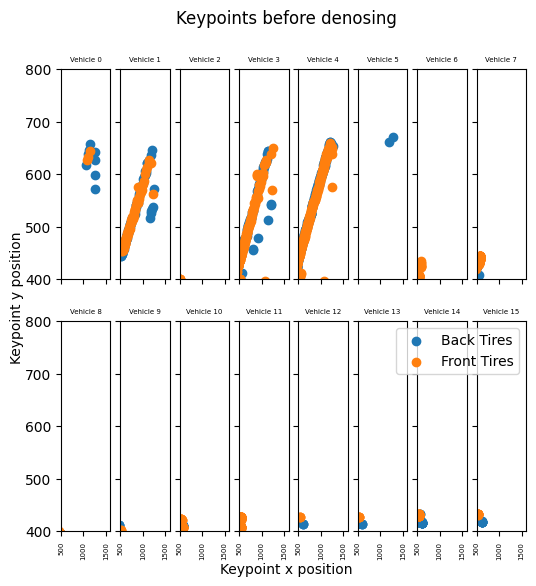

In [9]:
objectwise_keypoints = get_objectwise_keypoints(False, False, False)
object_names = list(objectwise_keypoints.keys())
fig, ax = plt.subplots(nrows=2, ncols=8, sharex=True, sharey=True, figsize=(6, 6))
fig.text(0.5, 0.04, 'Keypoint x position', ha='center')
fig.text(0.04, 0.5, 'Keypoint y position', va='center', rotation='vertical')
for i, object_name in tqdm(enumerate(object_names)):
    back_tire_x_list = []
    back_tire_y_list = []
    front_tire_x_list = []
    front_tire_y_list = []
    for keypoints_per_frame in objectwise_keypoints[object_name]:
        back_tire_x, back_tire_y, front_tire_x, front_tire_y = keypoints_per_frame
        back_tire_x_list.append(back_tire_x)
        back_tire_y_list.append(back_tire_y)
        front_tire_x_list.append(front_tire_x)
        front_tire_y_list.append(front_tire_y)
    plt.subplot(2,8,i + 1)
    plt.scatter(back_tire_x_list, back_tire_y_list, label = "Back Tires");
    plt.scatter(front_tire_x_list, front_tire_y_list, label = "Front Tires");
    plt.locator_params(axis='x', nbins=3)
    plt.xticks(fontsize=5,rotation = 90)
    plt.xlim([500,1600])
    plt.ylim([400,800])
    plt.title(f"Vehicle {i}", fontsize=5)
plt.suptitle("Keypoints before denosing");
plt.legend();

16it [00:00, 156.20it/s]


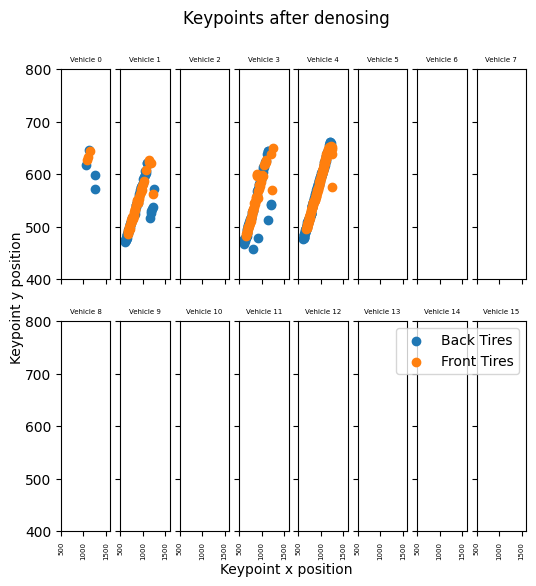

In [10]:
objectwise_keypoints = get_objectwise_keypoints(True, True, True)
object_names = list(objectwise_keypoints.keys())
fig, ax = plt.subplots(nrows=2, ncols=8, sharex=True, sharey=True, figsize=(6, 6))
fig.text(0.5, 0.04, 'Keypoint x position', ha='center')
fig.text(0.04, 0.5, 'Keypoint y position', va='center', rotation='vertical')
for i, object_name in tqdm(enumerate(object_names)):
    back_tire_x_list = []
    back_tire_y_list = []
    front_tire_x_list = []
    front_tire_y_list = []
    for keypoints_per_frame in objectwise_keypoints[object_name]:
        back_tire_x, back_tire_y, front_tire_x, front_tire_y = keypoints_per_frame
        back_tire_x_list.append(back_tire_x)
        back_tire_y_list.append(back_tire_y)
        front_tire_x_list.append(front_tire_x)
        front_tire_y_list.append(front_tire_y)
    plt.subplot(2,8,i + 1)
    plt.scatter(back_tire_x_list, back_tire_y_list, label = "Back Tires");
    plt.scatter(front_tire_x_list, front_tire_y_list, label = "Front Tires");
    plt.locator_params(axis='x', nbins=3)
    plt.xticks(fontsize=5,rotation = 90)
    plt.xlim([500,1600])
    plt.ylim([400,800])
    plt.title(f"Vehicle {i}", fontsize=5)
plt.suptitle("Keypoints after denosing");
plt.legend();